See [single_slit_modeling](single_slit_modeling.ipynb) for explanation of the problem

In [1]:
from pathlib import Path
#import psutil
#import pickle

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import constants

from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler


from jwst import datamodels

%matplotlib inline
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.pipeline import make_pipeline

from sklearn import svm
from sklearn.preprocessing import StandardScaler

# Data loading

In [3]:
slit_name = 's00066'

redux_path = Path(f'data/jwst_outputs/redux_{slit_name}/')

In [4]:
cal_paths = list(redux_path.glob('*cal.fits'))
cal_paths

[PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00001_nrs1_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00002_nrs2_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00002_nrs1_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00001_nrs2_cal.fits')]

In [5]:
cal_dms = {p.name: datamodels.open(p) for p in tqdm(cal_paths)}
cal_dms

  0%|          | 0/4 [00:00<?, ?it/s]

{'jw02609010001_03101_00001_nrs1_cal.fits': <MultiSlitModel from jw02609010001_03101_00001_nrs1_cal.fits>,
 'jw02609010001_03101_00002_nrs2_cal.fits': <MultiSlitModel from jw02609010001_03101_00002_nrs2_cal.fits>,
 'jw02609010001_03101_00002_nrs1_cal.fits': <MultiSlitModel from jw02609010001_03101_00002_nrs1_cal.fits>,
 'jw02609010001_03101_00001_nrs2_cal.fits': <MultiSlitModel from jw02609010001_03101_00001_nrs2_cal.fits>}

In [6]:
slit_all = {}
for k, dm in cal_dms.items():
    matches = np.array([s.source_id for s in dm.slits]) == 42
    assert np.sum(matches)==1
    idx = np.where(matches)[0][0]

    slit_all[k] = dm.slits[idx]

In [7]:
slit_all.keys()

dict_keys(['jw02609010001_03101_00001_nrs1_cal.fits', 'jw02609010001_03101_00002_nrs2_cal.fits', 'jw02609010001_03101_00002_nrs1_cal.fits', 'jw02609010001_03101_00001_nrs2_cal.fits'])

In [8]:
slit = slit_all['jw02609010001_03101_00002_nrs2_cal.fits']

In [18]:
#phoenix_model = fits.open('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z+0.5/lte04700-3.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits', cache=True)
phoenix_model = fits.open('phoenix/lte04700-3.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#phoenix_wave = fits.getdata('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS//WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', cache=True)*u.angstrom
phoenix_wave = fits.getdata('phoenix/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')*u.angstrom

phoenix_spec = Spectrum1D(spectral_axis=phoenix_wave, flux=phoenix_model[0].data*u.Unit(phoenix_model[0].header['BUNIT']))

2024-03-06 19:53:18,061 - stpipe - WARNING - UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard


In [19]:
wls = np.quantile(slit.wavelength[np.isfinite(slit.wavelength)], [0, .5,1])*u.micron

msk = (wls[0] <= phoenix_spec.spectral_axis) & (phoenix_spec.spectral_axis<=wls[-1])

phoenix_sub_spec = Spectrum1D(spectral_axis=phoenix_spec.spectral_axis[msk], 
                                        flux=phoenix_spec.flux[msk])

In [20]:
dmodel = np.diff(phoenix_sub_spec.spectral_axis)

phoenix_lowres_wls_dlamb = np.max(dmodel)*10
phoenix_lowres_wl_bins = np.arange(wls[0].to(phoenix_lowres_wls_dlamb.unit).value, 
                                   wls[-1].to(phoenix_lowres_wls_dlamb.unit).value, 
                                   phoenix_lowres_wls_dlamb.to(phoenix_lowres_wls_dlamb.unit).value)*phoenix_lowres_wls_dlamb.unit

phoenix_lowres = FluxConservingResampler().resample1d(phoenix_sub_spec, 
                            (phoenix_lowres_wl_bins[:-1] + phoenix_lowres_wl_bins[1:])/2)

len(phoenix_lowres.spectral_axis)/slit.data.shape[1]  # tells how much better sampled the "low" res spectrum is from the data

11.77783203125

# Interpolation tests

## Full-range velocity

In [21]:
xms = []
yms = []
vs = np.linspace(-1000, 1000, 100) << u.km/u.s
for v in tqdm(vs):
    zp1 = v/constants.c + 1
    x_model, y_model = slit.meta.wcs.world_to_pixel(SkyCoord((slit.source_ra<<u.deg),  (slit.source_dec<<u.deg)), phoenix_lowres.spectral_axis* zp1)
    xms.append(x_model)
    yms.append(y_model)
xms = np.array(xms)
yms = np.array(yms)

  0%|          | 0/100 [00:00<?, ?it/s]

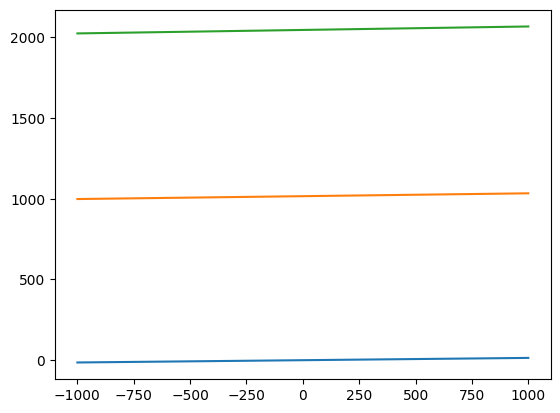

In [22]:
for i in [0, xms.shape[1]//2, -1]:
    plt.plot(vs, xms[:,i])

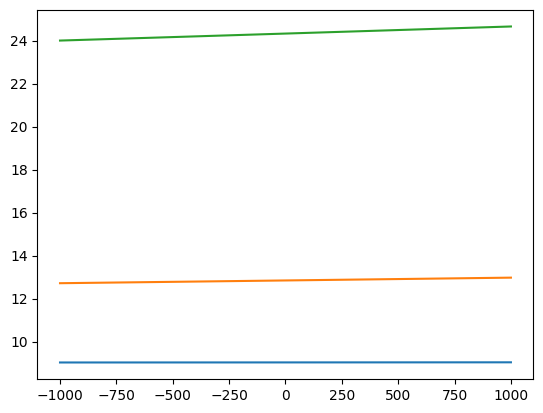

In [23]:
for i in [0, yms.shape[1]//2, -1]:
    plt.plot(vs, yms[:,i])

Subtract off a line to see the residuals

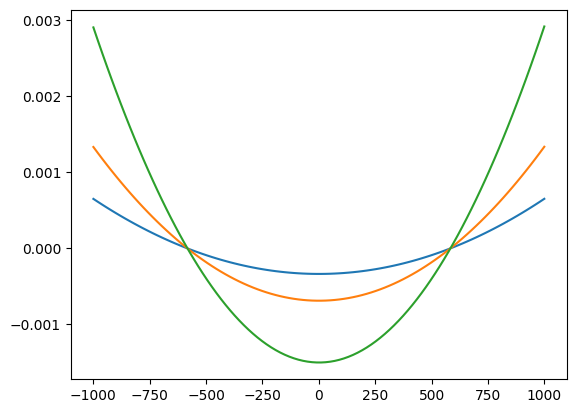

In [24]:
for i in [0, xms.shape[1]//2, -1]:
    p = np.polynomial.Polynomial.fit(vs, xms[:, i], 1)
    plt.plot(vs, (xms[:, i] - p(vs.value)))

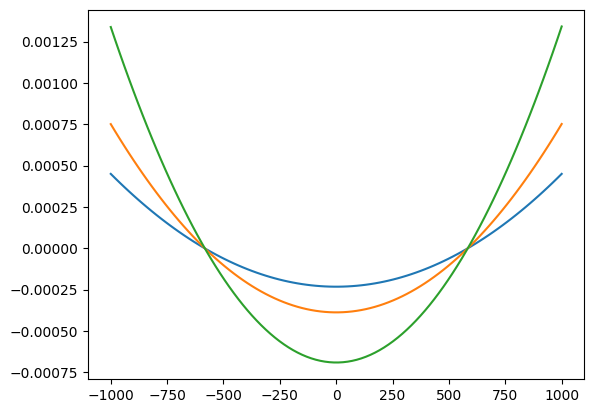

In [25]:
for i in [0, xms.shape[1]//2, -1]:
    p = np.polynomial.Polynomial.fit(vs, yms[:, i], 1)
    plt.plot(vs, (yms[:, i] - p(vs.value)))

## Near-0 velocity

In [26]:
xms = []
yms = []
vs = np.linspace(-1, 1, 100) << u.km/u.s
for v in tqdm(vs):
    zp1 = v/constants.c + 1
    x_model, y_model = slit.meta.wcs.world_to_pixel(SkyCoord((slit.source_ra<<u.deg),  (slit.source_dec<<u.deg)), phoenix_lowres.spectral_axis* zp1)
    xms.append(x_model)
    yms.append(y_model)
xms = np.array(xms)
yms = np.array(yms)

  0%|          | 0/100 [00:00<?, ?it/s]

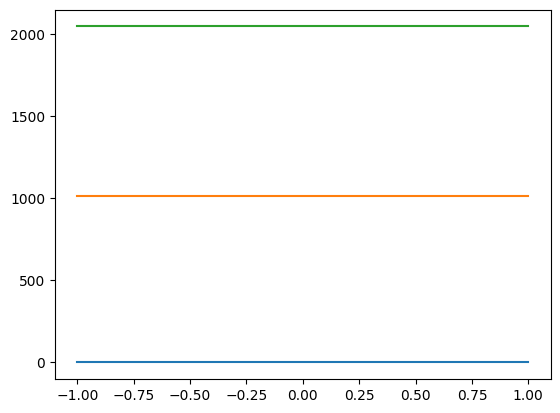

In [27]:
for i in [0, xms.shape[1]//2, -1]:
    plt.plot(vs, xms[:,i])

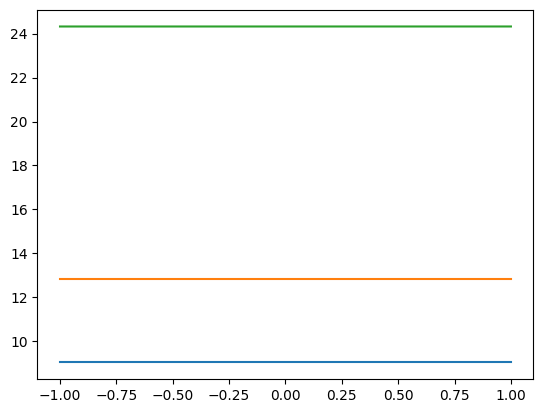

In [28]:
for i in [0, yms.shape[1]//2, -1]:
    plt.plot(vs, yms[:,i])

Subtract off a line to see the residuals

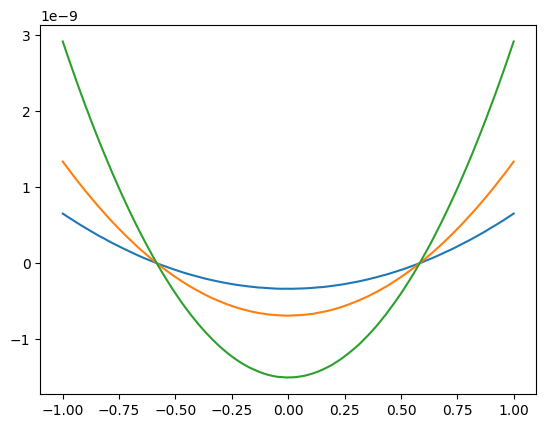

In [29]:
for i in [0, xms.shape[1]//2, -1]:
    p = np.polynomial.Polynomial.fit(vs, xms[:, i], 1)
    plt.plot(vs, (xms[:, i] - p(vs.value)))

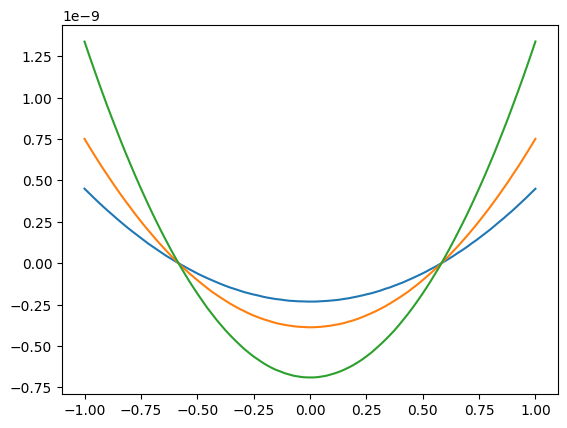

In [30]:
for i in [0, yms.shape[1]//2, -1]:
    p = np.polynomial.Polynomial.fit(vs, yms[:, i], 1)
    plt.plot(vs, (yms[:, i] - p(vs.value)))

OK, it seems like its linear to .001ths of a pixel over 1000 km/s, so probably that's sufficient

## RA offset

In [31]:
xms = []
yms = []
oss = np.linspace(-1, 1, 100) << u.arcsec
for o in tqdm(oss):
    x_model, y_model = slit.meta.wcs.world_to_pixel(SkyCoord((slit.source_ra<<u.deg)+o,  (slit.source_dec<<u.deg)), phoenix_lowres.spectral_axis)
    xms.append(x_model)
    yms.append(y_model)
xms = np.array(xms)
yms = np.array(yms)

  0%|          | 0/100 [00:00<?, ?it/s]

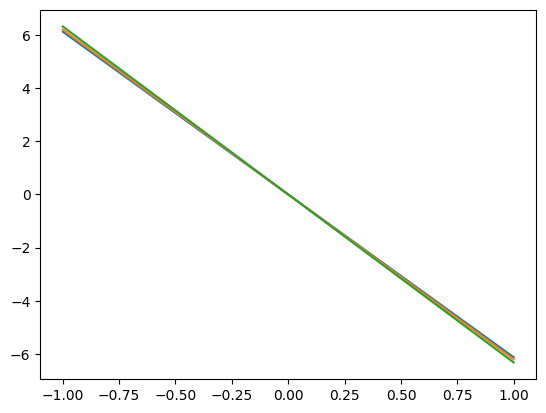

In [32]:
for i in [0, xms.shape[1]//2, -1]:
    plt.plot(oss, xms[:,i] - xms[:,i].mean())

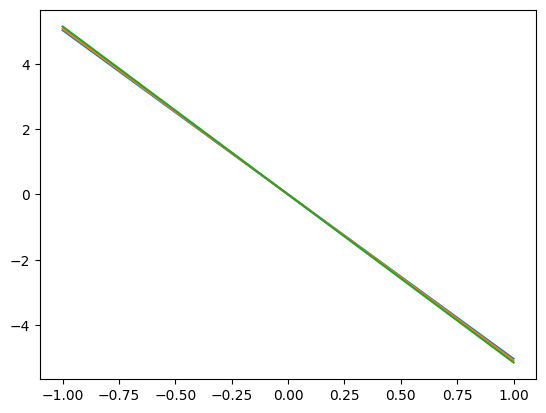

In [33]:
for i in [0, yms.shape[1]//2, -1]:
    plt.plot(oss, yms[:,i] - yms[:,i].mean())

Hard to say how linear that is.  Try fitting a line and removing that

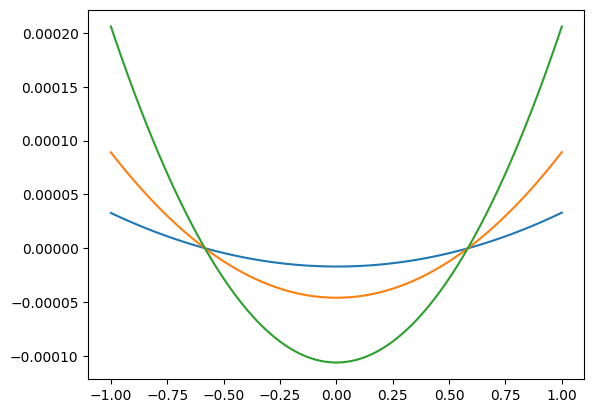

In [34]:
for i in [0, xms.shape[1]//2, -1]:
    p = np.polynomial.Polynomial.fit(oss, xms[:, i], 1)
    plt.plot(oss, (xms[:, i] - p(oss.value)))

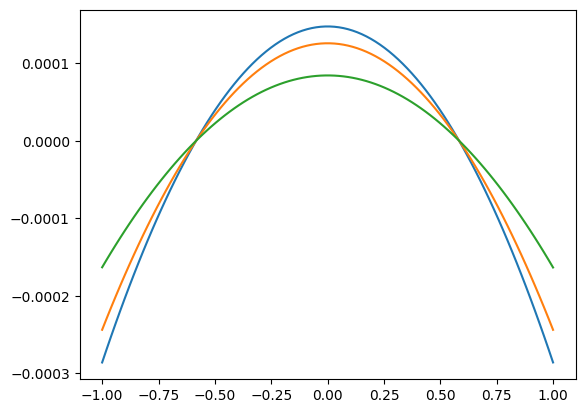

In [35]:
for i in [0, yms.shape[1]//2, -1]:
    p = np.polynomial.Polynomial.fit(oss, yms[:, i], 1)
    plt.plot(oss, (yms[:, i] - p(oss.value)))

## Dec offset

In [36]:
xms = []
yms = []
oss = np.linspace(-1, 1, 100) << u.arcsec
for o in tqdm(oss):
    x_model, y_model = slit.meta.wcs.world_to_pixel(SkyCoord((slit.source_ra<<u.deg),  (slit.source_dec<<u.deg) + o), phoenix_lowres.spectral_axis)
    xms.append(x_model)
    yms.append(y_model)
xms = np.array(xms)
yms = np.array(yms)

  0%|          | 0/100 [00:00<?, ?it/s]

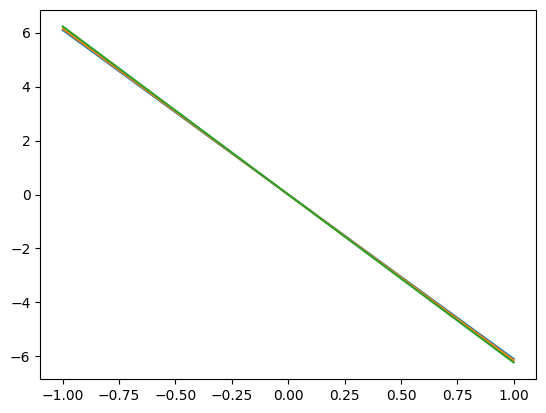

In [37]:
for i in [0, xms.shape[1]//2, -1]:
    plt.plot(oss, xms[:,i] - xms[:,i].mean())

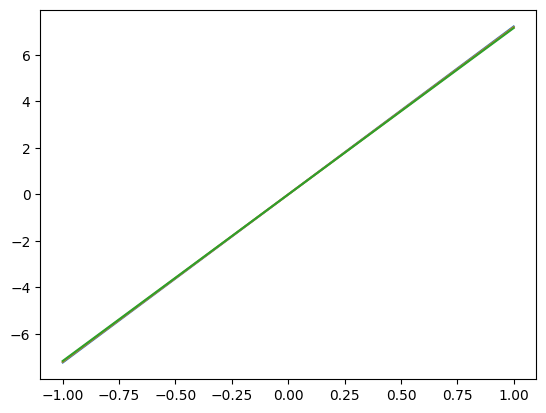

In [38]:
for i in [0, yms.shape[1]//2, -1]:
    plt.plot(oss, yms[:,i] - yms[:,i].mean())

Hard to say how linear that is.  Try fitting a line and removing that

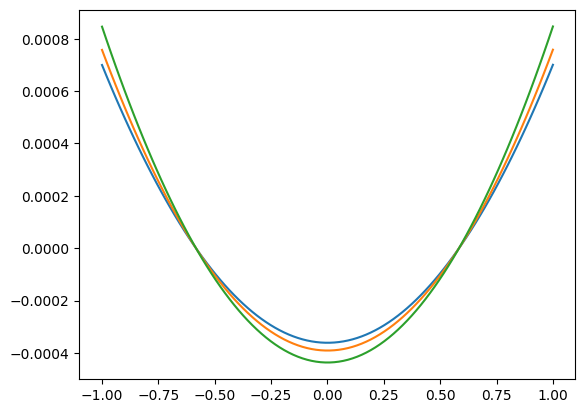

In [39]:
for i in [0, xms.shape[1]//2, -1]:
    p = np.polynomial.Polynomial.fit(oss, xms[:, i], 1)
    plt.plot(oss, (xms[:, i] - p(oss.value)))

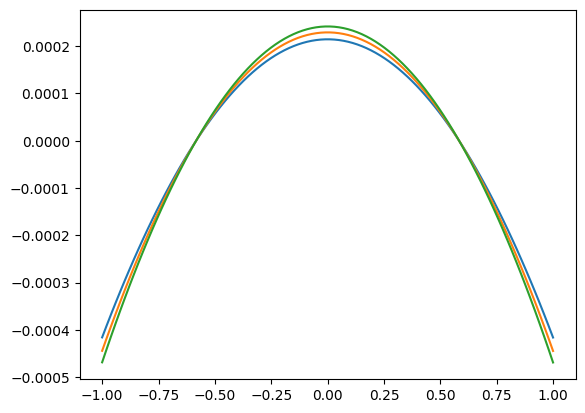

In [40]:
for i in [0, yms.shape[1]//2, -1]:
    p = np.polynomial.Polynomial.fit(oss, yms[:, i], 1)
    plt.plot(oss, (yms[:, i] - p(oss.value)))

## Mixed ra/dec opposite sign

In [41]:
xms = []
yms = []
oss = np.linspace(-1, 1, 100) << u.arcsec
for o in tqdm(oss):
    x_model, y_model = slit.meta.wcs.world_to_pixel(SkyCoord((slit.source_ra<<u.deg) + o,  (slit.source_dec<<u.deg) - o), phoenix_lowres.spectral_axis)
    xms.append(x_model)
    yms.append(y_model)
xms = np.array(xms)
yms = np.array(yms)

  0%|          | 0/100 [00:00<?, ?it/s]

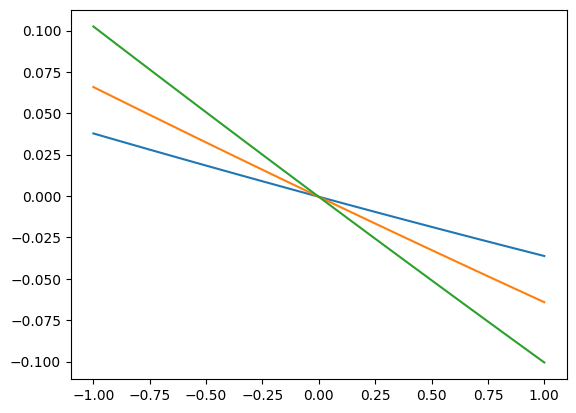

In [42]:
for i in [0, xms.shape[1]//2, -1]:
    plt.plot(oss, xms[:,i] - xms[:,i].mean())

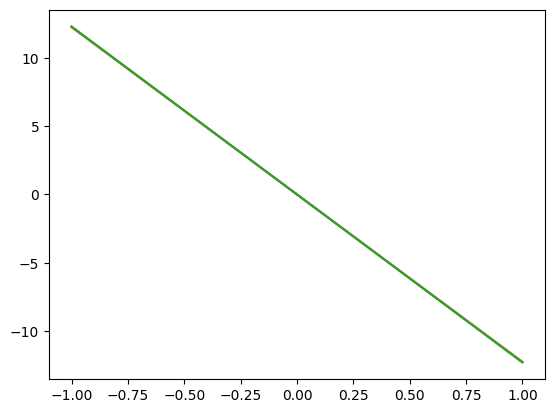

In [43]:
for i in [0, yms.shape[1]//2, -1]:
    plt.plot(oss, yms[:,i] - yms[:,i].mean())

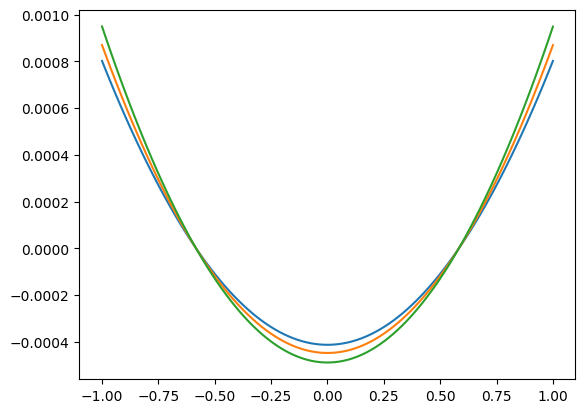

In [44]:
for i in [0, xms.shape[1]//2, -1]:
    p = np.polynomial.Polynomial.fit(oss, xms[:, i], 1)
    plt.plot(oss, (xms[:, i] - p(oss.value)))

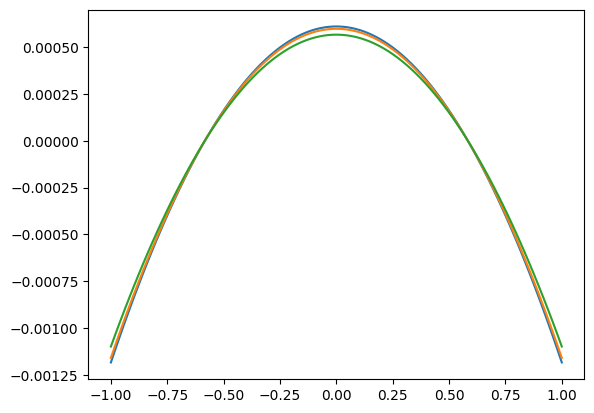

In [45]:
for i in [0, yms.shape[1]//2, -1]:
    p = np.polynomial.Polynomial.fit(oss, yms[:, i], 1)
    plt.plot(oss, (yms[:, i] - p(oss.value)))

## All together now

In [46]:
xms = []
yms = []
vs = np.linspace(-1000, 1000, 100) << u.km/u.s
oss = np.linspace(-1, 1, 100) << u.arcsec
for v, o in tqdm(list(zip(vs,oss))):
    zp1 = v/constants.c + 1
    x_model, y_model = slit.meta.wcs.world_to_pixel(SkyCoord((slit.source_ra<<u.deg) + o,  (slit.source_dec<<u.deg) - o), phoenix_lowres.spectral_axis* zp1)
    xms.append(x_model)
    yms.append(y_model)
xms = np.array(xms)
yms = np.array(yms)

  0%|          | 0/100 [00:00<?, ?it/s]

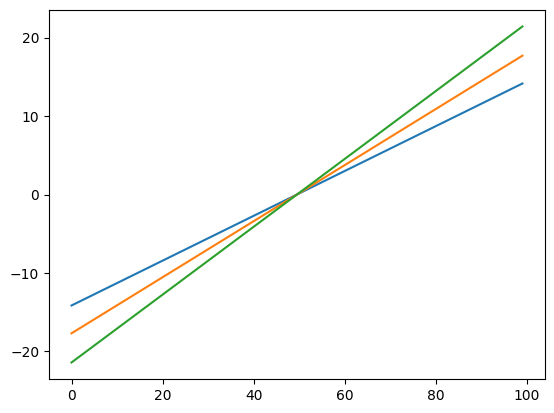

In [47]:
for i in [0, xms.shape[1]//2, -1]:
    plt.plot(xms[:,i] - xms[:,i].mean())

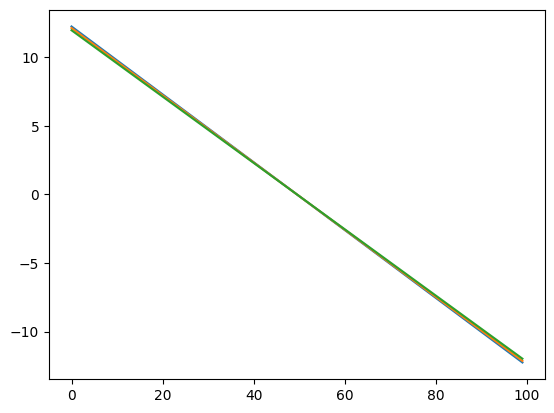

In [48]:
for i in [0, yms.shape[1]//2, -1]:
    plt.plot(yms[:,i] - yms[:,i].mean())

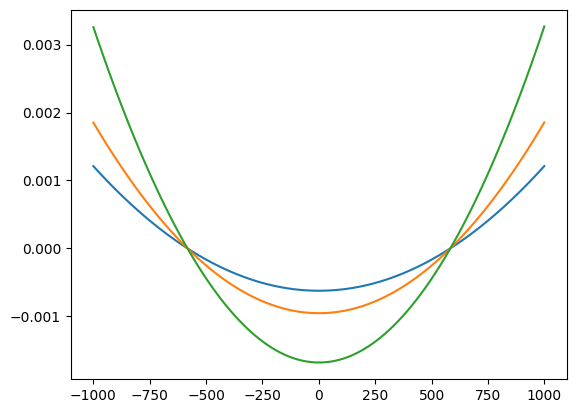

In [49]:
for i in [0, xms.shape[1]//2, -1]:
    p = np.polynomial.Polynomial.fit(vs, xms[:, i], 1)
    plt.plot(vs, (xms[:, i] - p(vs.value)))

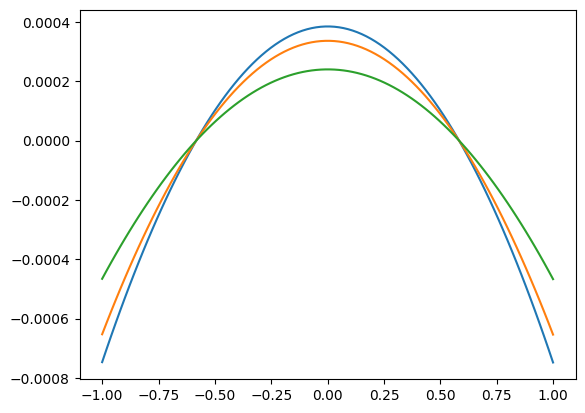

In [50]:
for i in [0, yms.shape[1]//2, -1]:
    p = np.polynomial.Polynomial.fit(oss, yms[:, i], 1)
    plt.plot(oss, (yms[:, i] - p(oss.value)))

OK even combined we stay within .001 or so of a pixel... what about a 2nd order polynomial?

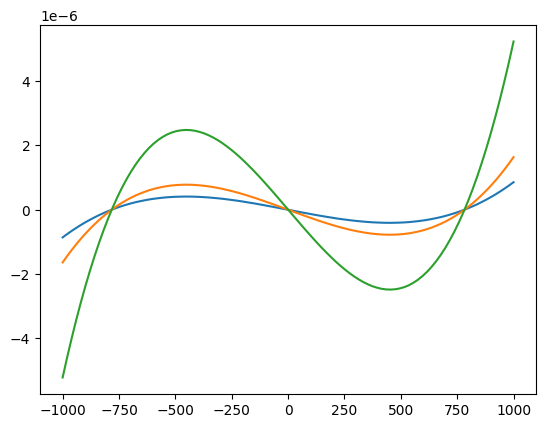

In [51]:
for i in [0, xms.shape[1]//2, -1]:
    p = np.polynomial.Polynomial.fit(vs, xms[:, i], 2)
    plt.plot(vs, (xms[:, i] - p(vs.value)))

Might be worth it to go to second order.   

### Grid it up

In [52]:
from scipy import interpolate

In [53]:
vs = np.linspace(-1000, 1000, 11)
oss = np.linspace(-1, 1, 11)

grid = np.array(np.meshgrid(vs, oss, oss))
vgrid, raogrid, decogrid = grid

In [54]:
zp1g = (vgrid << u.km/u.s)/constants.c + 1
x_modelg, y_modelg = slit.meta.wcs.world_to_pixel(SkyCoord((slit.source_ra<<u.deg) + (raogrid << u.arcsec),  (slit.source_dec<<u.deg) + (decogrid << u.arcsec)), 
                                                  phoenix_lowres.spectral_axis[:, np.newaxis, np.newaxis, np.newaxis]*zp1g.value)

In [55]:
grid_interp = interpolate.RegularGridInterpolator((phoenix_lowres.spectral_axis.value, vs, oss, oss), x_modelg)

In [56]:
x = np.array([phoenix_lowres.spectral_axis.value,[10]*len(phoenix_lowres.spectral_axis.value),[.5]*len(phoenix_lowres.spectral_axis.value),[.5]*len(phoenix_lowres.spectral_axis.value)])
%timeit grid_interp.__call__(x.T)

12.2 ms ± 280 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
%%timeit 

x = np.array([phoenix_lowres.spectral_axis.value,[10]*len(phoenix_lowres.spectral_axis.value),[.5]*len(phoenix_lowres.spectral_axis.value),[.5]*len(phoenix_lowres.spectral_axis.value)])
xm = grid_interp.__call__(x.T)

15 ms ± 376 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [58]:
x = np.array([phoenix_lowres.spectral_axis.value,[0]*len(phoenix_lowres.spectral_axis.value),[0]*len(phoenix_lowres.spectral_axis.value),[0]*len(phoenix_lowres.spectral_axis.value)])
xm = grid_interp.__call__(x.T)

In [59]:
%%timeit 

xm0 = slit.meta.wcs.world_to_pixel(SkyCoord((slit.source_ra<<u.deg),  (slit.source_dec<<u.deg)),
                                    phoenix_lowres.spectral_axis)[0]

72.2 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
xm0 = slit.meta.wcs.world_to_pixel(SkyCoord((slit.source_ra<<u.deg),  (slit.source_dec<<u.deg)),
                                    phoenix_lowres.spectral_axis)[0]

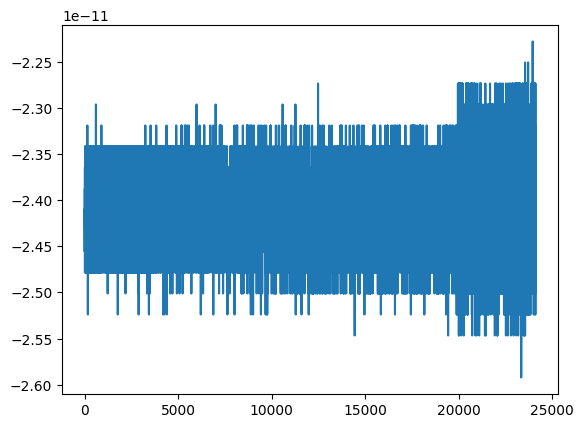

In [61]:
plt.plot(xm0 - xm)

Accurate but still dominating the time budget... lets try some other approaches like building explicit polynomial models.

# Polynomial Models

In [62]:
vs = np.linspace(-1000, 1000, 13)
oss = np.linspace(-1, 1, 11)

grid = np.array(np.meshgrid(vs, oss, oss, indexing='ij'))
vgrid, raogrid, decogrid = grid

In [63]:
saxis = np.linspace(phoenix_lowres.spectral_axis[0], phoenix_lowres.spectral_axis[-1], 27)
saxis.shape

(27,)

In [64]:
zp1g = (vgrid << u.km/u.s)/constants.c + 1
xm0, ym0 = slit.meta.wcs.world_to_pixel(SkyCoord((slit.source_ra<<u.deg) + (vgrid << u.arcsec),  
                                                 (slit.source_dec<<u.deg) + (vgrid << u.arcsec)),
                                                np.multiply.outer(saxis, zp1g))

xm0.shape

/usr/local/lib/python3.11/site-packages/stdatamodels/jwst/transforms/models.py:1550: RuntimeWarning: invalid value encountered in sqrt
  zout = np.sqrt(1 - xout**2 - yout**2)


(27, 13, 11, 11)

In [65]:
gridall = np.array(np.meshgrid(saxis.value, vs, oss, oss, indexing='ij'))
gridall.shape, gridall.size/gridall.shape[0]

((4, 27, 13, 11, 11), 42471.0)

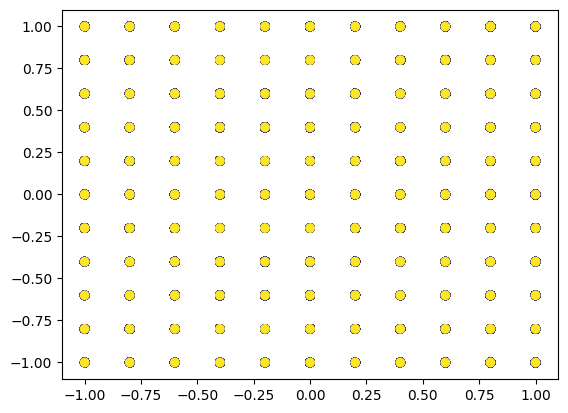

In [66]:
plt.scatter(gridall[2].ravel(),gridall[3].ravel(), c=xm0.ravel())

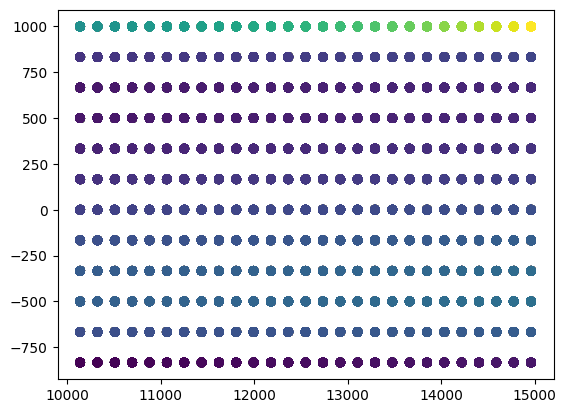

In [67]:
plt.scatter(gridall[0].ravel(),gridall[1].ravel(), c=xm0.ravel())

In [68]:
gridallflat = gridall.reshape(gridall.shape[0], gridall.size//gridall.shape[0])
xm0flat = xm0.reshape(xm0.shape[0], xm0.size//xm0.shape[0])
ym0flat = ym0.reshape(ym0.shape[0], ym0.size//ym0.shape[0])

In [69]:
pdegree = 2

poly = PolynomialFeatures(pdegree)
pgrid = poly.fit_transform(gridallflat.T)
pgrid.shape

(42471, 15)

In [70]:
np.sum(np.isnan(xm0.ravel()))/xm0.size

0.07692307692307693

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.927e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


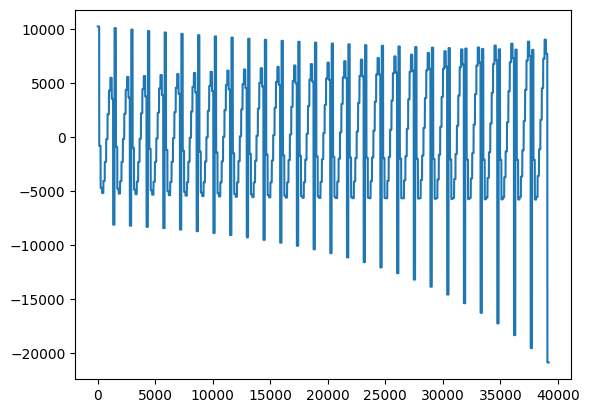

In [71]:
notnan = ~np.isnan(xm0.ravel())

modelx = make_pipeline(PolynomialFeatures(pdegree), Ridge(alpha=1e-3))
modelx.fit(gridallflat[:, notnan].T, xm0.ravel()[notnan])

plt.plot(modelx.predict(gridallflat[:, notnan].T) - xm0.ravel()[notnan])

Well that's utter non-sense.  Lets try doing it a bit more manually

In [72]:
coeffs = np.linalg.pinv(pgrid[notnan]) @ xm0.ravel()[notnan]

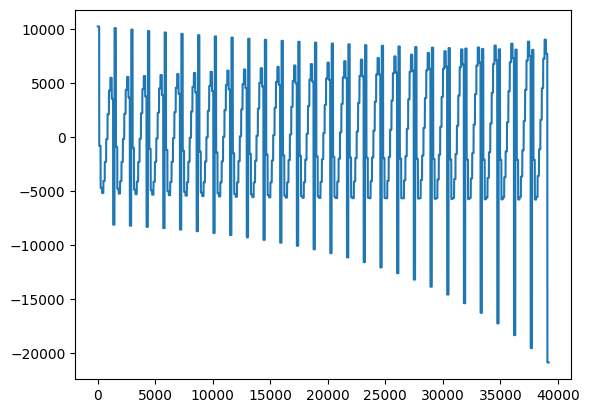

In [73]:
plt.plot(pgrid[notnan] @ coeffs - xm0.ravel()[notnan])

Whelp, that explains it. Maybe have the pixel dimension be the stack?

In [74]:
pgridstack = pgrid.reshape(saxis.size, pgrid.shape[0]//saxis.size, pgrid.shape[-1])
pgridstack.shape

(27, 1573, 15)

In [75]:
xm0stack = xm0.reshape(xm0.shape[0], xm0.size//xm0.shape[0])
xm0stack.shape

(27, 1573)

In [76]:
nanmsk = np.any(np.isnan(xm0stack), axis=0)
coeffs = np.linalg.pinv(pgridstack)[5][:, ~nanmsk] @ xm0.reshape(xm0.shape[0], xm0.size//xm0.shape[0])[5, ~nanmsk]
coeffs.shape

(15,)

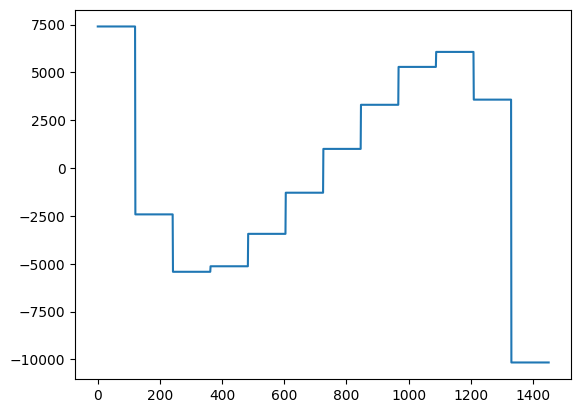

In [77]:
plt.plot(pgridstack[5][~nanmsk] @ coeffs - xm0stack[5][~nanmsk])

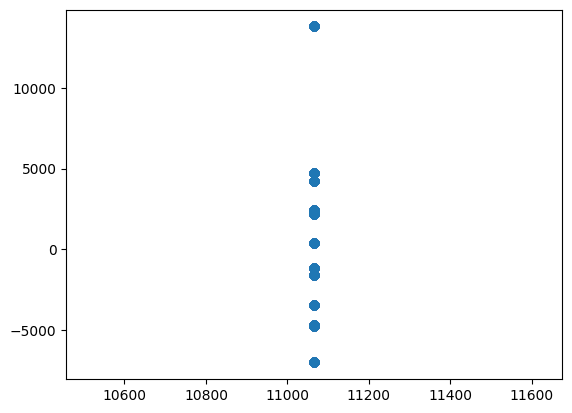

In [78]:
plt.scatter(pgridstack[5,~nanmsk,1], xm0stack[5][~nanmsk])

In [79]:
pgridstack[5,~nanmsk,2]

array([-833.33333333, -833.33333333, -833.33333333, ..., 1000.        ,
       1000.        , 1000.        ])

None of this is working either. Maybe we try some other sklearn approaches like SVMs?

# SVMs

In [80]:
notnan = ~np.isnan(xm0.ravel())

xfit = gridallflat[:, notnan].T
yfit = xm0.ravel()[notnan]

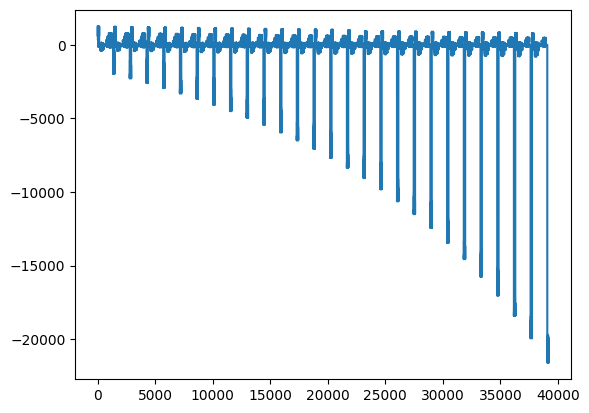

In [81]:
svr_rbf = svm.SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)

svr_rbf.fit(xfit, yfit)

plt.plot(svr_rbf.predict(xfit) - yfit)

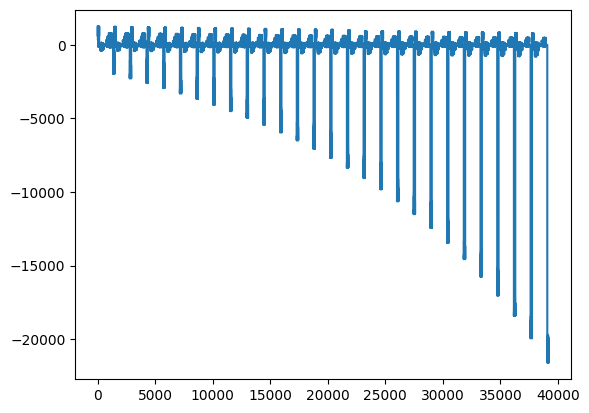

In [82]:
svr_lin = svm.SVR(kernel="linear", C=100, gamma="auto")

svr_rbf.fit(xfit, yfit)

plt.plot(svr_rbf.predict(xfit) - yfit)

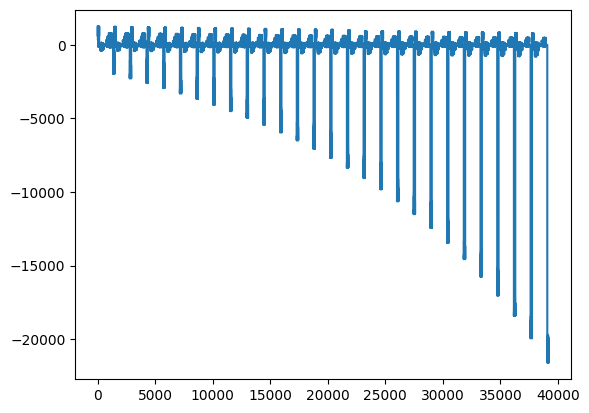

In [83]:
svr_poly = svm.SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)

svr_rbf.fit(xfit, yfit)

plt.plot(svr_rbf.predict(xfit) - yfit)

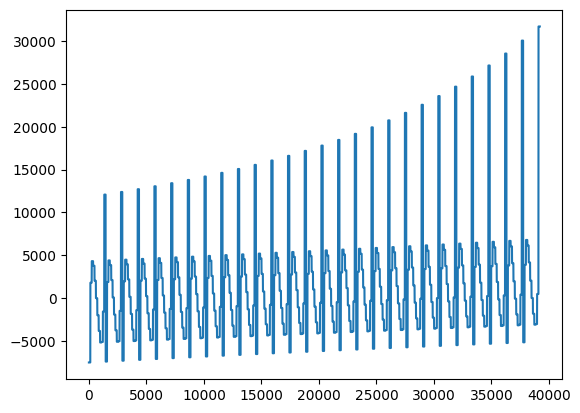

In [84]:
plt.plot(yfit)

Clearly having a lot of trouble capturing the edges...

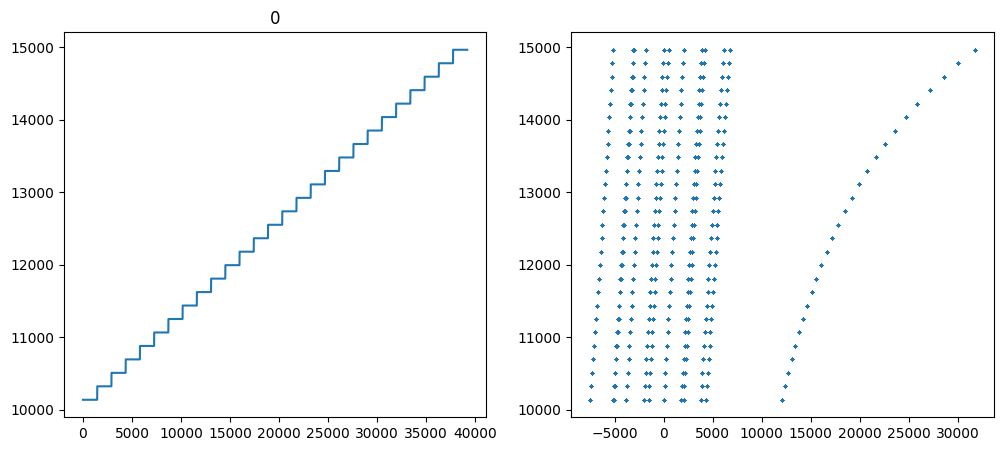

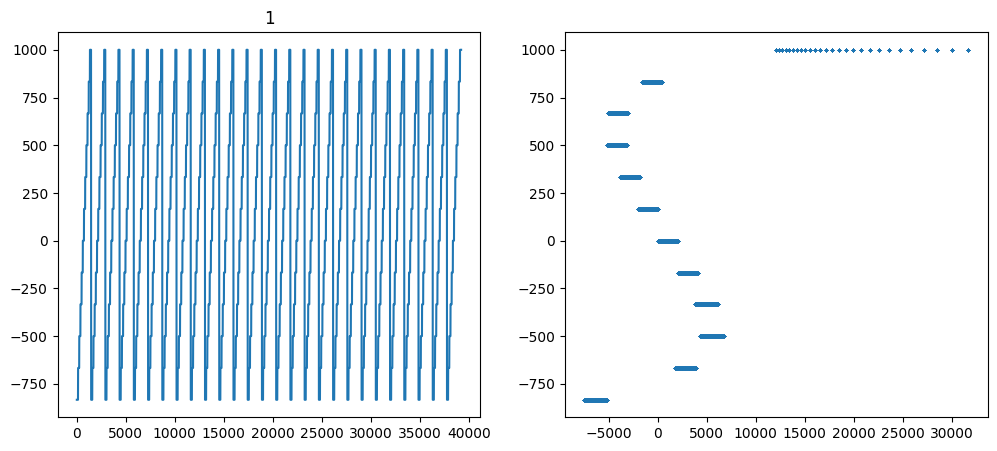

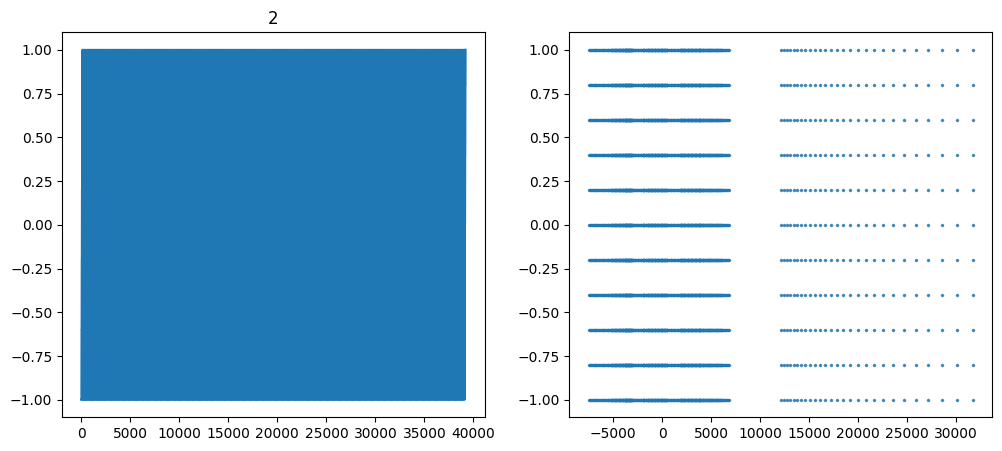

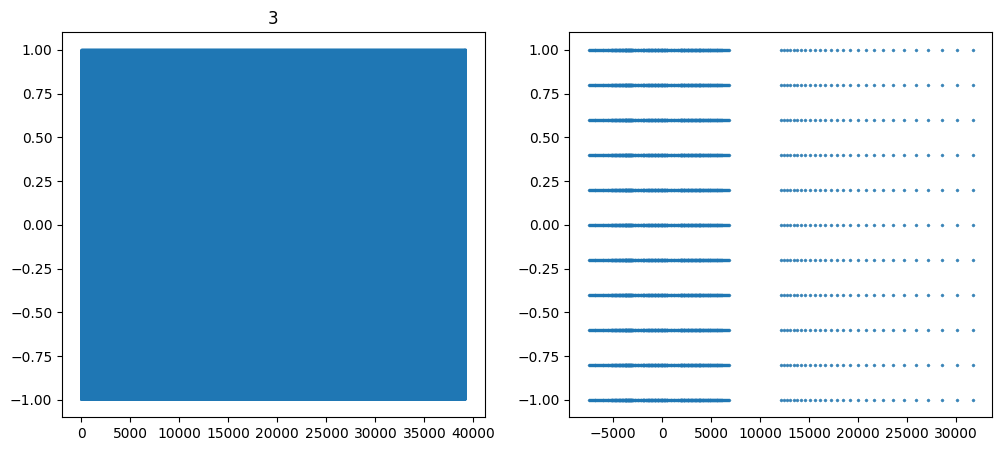

In [85]:
for i, xi in  enumerate(xfit.T):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(xi)
    ax2.scatter(yfit, xi, s=2, alpha=.1)
    ax1.set_title(str(i))

D'OH! There was a mistake above - `oss` was replaced by `vgrid` in the calculation above.  Re-try some of the methods

(27, 13, 11, 11)

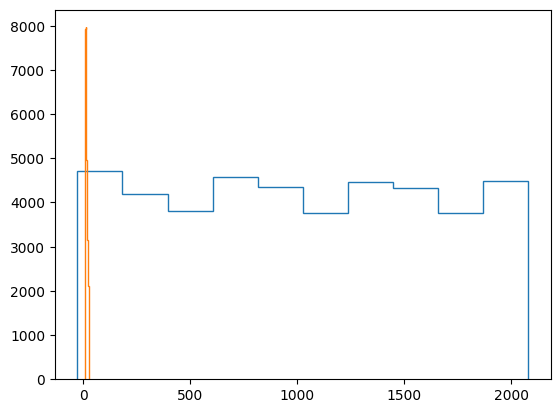

In [86]:
vs = np.linspace(-1000, 1000, 13)
oss = np.linspace(-1, 1, 11)

grid = np.array(np.meshgrid(vs, oss, oss, indexing='ij'))
vgrid, raogrid, decogrid = grid

saxis = np.linspace(phoenix_lowres.spectral_axis[0], phoenix_lowres.spectral_axis[-1], 27)
saxis.shape

zp1g = (vgrid << u.km/u.s)/constants.c + 1
xm0, ym0 = slit.meta.wcs.world_to_pixel(SkyCoord((slit.source_ra<<u.deg) + (oss << u.arcsec),  
                                                 (slit.source_dec<<u.deg) + (oss << u.arcsec)),
                                                np.multiply.outer(saxis, zp1g))

plt.hist(xm0.ravel(), histtype='step')
plt.hist(ym0.ravel(), histtype='step')
xm0.shape

In [87]:
gridall = np.array(np.meshgrid(saxis.value, vs, oss, oss, indexing='ij'))

gridallflat = gridall.reshape(gridall.shape[0], gridall.size//gridall.shape[0])
xm0flat = xm0.reshape(xm0.shape[0], xm0.size//xm0.shape[0])
ym0flat = ym0.reshape(ym0.shape[0], ym0.size//ym0.shape[0])

In [88]:
notnan = ~np.isnan(xm0.ravel())

xfit = gridallflat[:, notnan].T
yfit = xm0.ravel()[notnan]

xfit.shape, yfit.shape, xfit.size

((42471, 4), (42471,), 169884)

In [89]:
xtimetest = xfit[:2000*20]

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.91454e-32): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


13.2 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


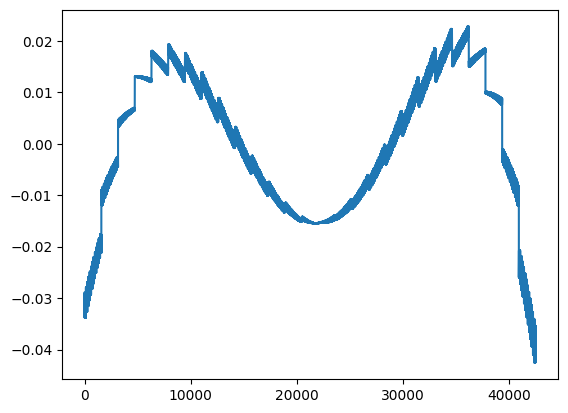

In [90]:
modelx = make_pipeline(PolynomialFeatures(3), Ridge(alpha=1e-3))
modelx.fit(xfit, yfit)

plt.plot(modelx.predict(xfit) - yfit)

%timeit modelx.predict(xtimetest)

OK, so at degree 3 we do ~.01 pixels, but still takes ~10 ms.  Might be optimizable on CUDA though?

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.6794e-41): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


26.5 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


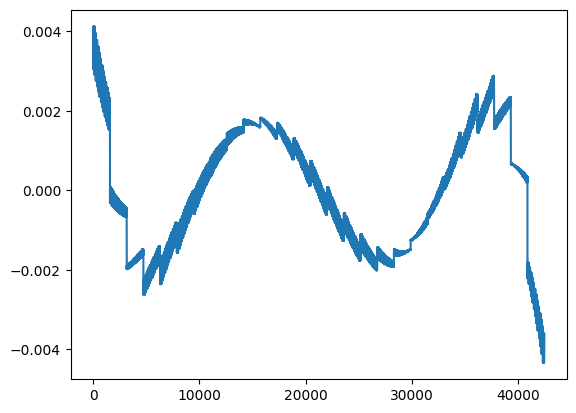

In [91]:
modelx = make_pipeline(PolynomialFeatures(4), Ridge(alpha=1e-4))
modelx.fit(xfit, yfit)

plt.plot(modelx.predict(xfit) - yfit)

%timeit modelx.predict(xtimetest)

In [92]:
poly = modelx.steps[0][-1]

poly.get_feature_names_out()

array(['1', 'x0', 'x1', 'x2', 'x3', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3',
       'x1^2', 'x1 x2', 'x1 x3', 'x2^2', 'x2 x3', 'x3^2', 'x0^3',
       'x0^2 x1', 'x0^2 x2', 'x0^2 x3', 'x0 x1^2', 'x0 x1 x2', 'x0 x1 x3',
       'x0 x2^2', 'x0 x2 x3', 'x0 x3^2', 'x1^3', 'x1^2 x2', 'x1^2 x3',
       'x1 x2^2', 'x1 x2 x3', 'x1 x3^2', 'x2^3', 'x2^2 x3', 'x2 x3^2',
       'x3^3', 'x0^4', 'x0^3 x1', 'x0^3 x2', 'x0^3 x3', 'x0^2 x1^2',
       'x0^2 x1 x2', 'x0^2 x1 x3', 'x0^2 x2^2', 'x0^2 x2 x3', 'x0^2 x3^2',
       'x0 x1^3', 'x0 x1^2 x2', 'x0 x1^2 x3', 'x0 x1 x2^2', 'x0 x1 x2 x3',
       'x0 x1 x3^2', 'x0 x2^3', 'x0 x2^2 x3', 'x0 x2 x3^2', 'x0 x3^3',
       'x1^4', 'x1^3 x2', 'x1^3 x3', 'x1^2 x2^2', 'x1^2 x2 x3',
       'x1^2 x3^2', 'x1 x2^3', 'x1 x2^2 x3', 'x1 x2 x3^2', 'x1 x3^3',
       'x2^4', 'x2^3 x3', 'x2^2 x3^2', 'x2 x3^3', 'x3^4'], dtype=object)

In [93]:
ridge = modelx.steps[1][-1]
ridge.coef_

array([ 0.00000000e+00,  3.86233637e-01, -1.49635308e-03, -1.60959118e-08,
       -1.12509959e+01,  3.31815310e-06,  1.77243936e-06,  3.90780105e-12,
       -1.96495094e-04,  1.17567835e-08,  8.33235294e-13, -1.03302999e-05,
        5.01401238e-09, -5.53862140e-12,  2.90556743e-03, -1.72566700e-10,
       -3.61490750e-11, -3.13688777e-16,  1.54613581e-08, -2.22651244e-12,
       -1.34081331e-16,  1.87736976e-09, -8.25381706e-13,  8.85717812e-16,
       -4.11506904e-07, -2.87756541e-14,  2.49440833e-18,  3.00080347e-11,
       -2.04167631e-15,  3.64354552e-16, -2.42038204e-08, -1.13975093e-12,
       -1.62216925e-05,  3.36518999e-12, -3.18284729e-05,  4.58616811e-15,
        1.36856927e-15,  8.32723140e-21, -5.42943689e-13,  1.15581064e-16,
        5.32439578e-21, -1.01269002e-13,  3.30492952e-17, -3.49611458e-20,
        2.22672476e-11,  2.73583523e-18, -1.98221918e-22, -3.24930029e-15,
        2.26854476e-19, -2.87410441e-20,  2.47403554e-12,  9.43993624e-17,
        1.27561569e-09, -

Anything else faster?

In [94]:
from sklearn.preprocessing import StandardScaler

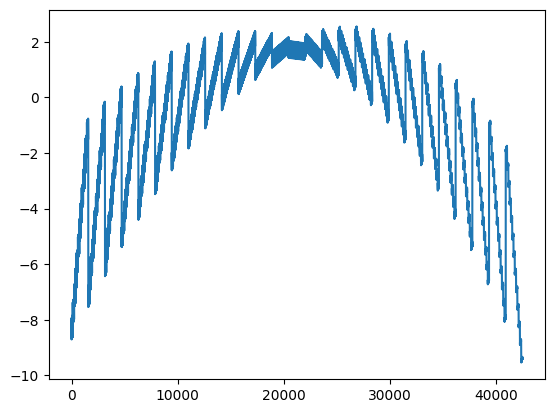

In [95]:
model = make_pipeline(StandardScaler(), svm.SVR(kernel="linear", C=100, gamma="auto"))
samps = np.random.permutation(xfit.shape[0])[:500]

model.fit(xfit[samps], yfit[samps])

plt.plot(model.predict(xfit) - yfit)

In [96]:
%timeit model.predict(xtimetest)

224 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


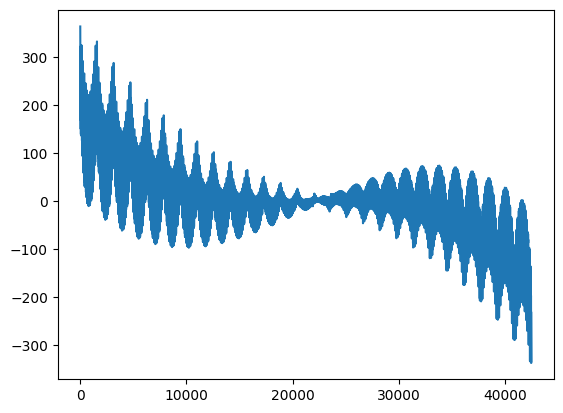

In [97]:
model = make_pipeline(StandardScaler(), svm.SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.01))
samps = np.random.permutation(xfit.shape[0])[:500]

model.fit(xfit[samps], yfit[samps])

plt.plot(model.predict(xfit) - yfit)

In [98]:
%timeit model.predict(xtimetest)

621 ms ± 4.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


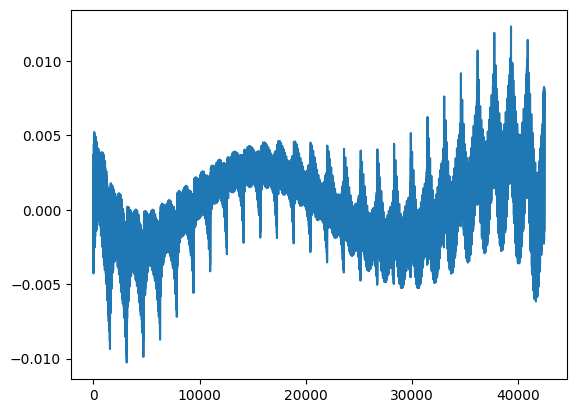

In [99]:
model = make_pipeline(StandardScaler(), svm.SVR(kernel="poly", C=100, gamma="auto", 
                                                degree=4, epsilon=0.003, coef0=1))
samps = np.random.permutation(xfit.shape[0])[:500]

model.fit(xfit[samps], yfit[samps])

plt.plot(model.predict(xfit) - yfit)

In [100]:
%timeit model.predict(xtimetest)

66.4 ms ± 524 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Neural Network

Can we do better with a neural network? Michelle's suggested structure:

* 4 inputs (actually 3?)
* fully connected (1024)
* leaky relu, 20% dropout
* fully connected (512)
* leaky relu, 20% dropout
* fully connected (256)
* leaky relu, 20% dropout
* fully connected (128)
* LINEAR
* N outputs (or N x 2 if x/y)


Adam optimizer first, SGD second

### Cuda/torch preliminaries

In [102]:
vs = np.linspace(-1000, 1000, 13)
oss = np.linspace(-1, 1, 11)

grid = np.array(np.meshgrid(vs, oss, oss, indexing='ij'))
vgrid, raogrid, decogrid = grid

saxis = np.linspace(phoenix_lowres.spectral_axis[0], phoenix_lowres.spectral_axis[-1], 27)
saxis.shape

zp1g = (vgrid << u.km/u.s)/constants.c + 1
xm0, ym0 = slit.meta.wcs.world_to_pixel(SkyCoord((slit.source_ra<<u.deg) + (oss << u.arcsec),  
                                                 (slit.source_dec<<u.deg) + (oss << u.arcsec)),
                                                np.multiply.outer(saxis, zp1g))

gridall = np.array(np.meshgrid(saxis.value, vs, oss, oss, indexing='ij'))

gridallflat = gridall.reshape(gridall.shape[0], gridall.size//gridall.shape[0])
xm0flat = xm0.reshape(xm0.shape[0], xm0.size//xm0.shape[0])
ym0flat = ym0.reshape(ym0.shape[0], ym0.size//ym0.shape[0])

notnan = ~np.isnan(xm0.ravel())

xfit = gridallflat[:, notnan].T
yfit = xm0.ravel()[notnan]

xtimetest = xfit[:2000*20]

xfit.shape, yfit.shape, xfit.size

((42471, 4), (42471,), 169884)

In [142]:
rng = np.random.default_rng(42)
rng.normal(), rng.normal(), rng.normal(), rng.normal(size=(2,2)),rng.normal()

(0.30471707975443135,
 -1.0399841062404955,
 0.7504511958064572,
 array([[ 0.94056472, -1.95103519],
        [-1.30217951,  0.1278404 ]]),
 -0.3162425923435822)

In [149]:
rng = np.random.default_rng(42)
rng.bit_generator.advance(7)
rng.normal()

-0.3162425923435822

In [113]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [104]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [105]:
for nm in 'cpu,cuda,cudnn,mps,mkl,mkldnn,openmp'.split(','):
    be = getattr(torch.backends, nm)
    built = be.is_built() if hasattr(be, 'is_built') else None
    avail = be.is_available() if hasattr(be, 'is_available') else None
    if avail is None and nm == 'cuda':
        avail = torch.cuda.is_available()
    print(nm, built, avail) 
              

cpu None None
cuda True True
cudnn None True
mps False False
mkl None True
mkldnn None True
openmp None True


In [106]:
torch_device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {torch_device} device")

Using cuda device


### Set up and run model

In [338]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, inN, outN):
        super().__init__()
        self.outN = outN
        self.primary_stack = nn.Sequential(
            nn.Linear(inN, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, outN),
        )

    def forward(self, x):
        return self.primary_stack(x)

nn2model = NeuralNetwork(4, 2)
print(nn2model)

NeuralNetwork(
  (primary_stack): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=256, out_features=2, bias=True)
  )
)


Now we work out the code to generate the batches from the wcs function

In [ ]:
sc = SkyCoord(1<<u.deg, 2<<u.deg)
ao = np.random.randn(128) << u.arcsec
bo = np.random.randn(128) << u.arcsec

%timeit sc.spherical_offsets_by(ao, bo)
%timeit SkyCoord((1<<u.deg)+ao, (2<<u.deg)+bo)

plt.hist(sc.spherical_offsets_by(ao, bo).separation(SkyCoord((1<<u.deg)+ao, (2<<u.deg)+bo)).marcsec)

a milliarcsec is small but not ignorable so lets do the "right" way just in case

In [340]:
params = 'lambda,velocity,raoff,decoff'.split(',')
lptp = np.ptp(phoenix_lowres.spectral_axis)
lmin = np.min(phoenix_lowres.spectral_axis)
def ptrans(urand): # 4 x batch size
    l = lptp*urand[0] + lmin
    v = (urand[1]*2000. - 1000.) << u.km/u.s
    ro = (urand[2]*2 - 1) << u.arcsec
    do = (urand[3]*2 - 1) << u.arcsec
    return l,v,ro,do

base_sc = SkyCoord(slit.source_ra<<u.deg, slit.source_dec<<u.deg)
def make_batch(rng, batch_size):
    l, v, ro, do = ptrans(rng.random(size=(len(params), batch_size)))
    
    zp1 = v/constants.c + 1
    l0 = l*zp1

    sc = base_sc.spherical_offsets_by(ro, do)
    
    outs = slit.meta.wcs.world_to_pixel(sc, l0)
    ins = np.array([l.value, v.value, ro.value, do.value])

    return ins, outs

In [341]:
rng = np.random.default_rng(42)

ins, (xo, yo) = make_batch(rng, 128) 
ins.shape, xo.shape, yo.shape

((4, 128), (128,), (128,))

Ok that all makes sense.  Proceed with model.

In [342]:
batch_size = 1024*8*4*4
n_batches = 150
seed = 42

nnmodel = NeuralNetwork(4, 2).to(torch_device)

X_test = torch.from_numpy(gridallflat.T.astype('float32')).to(torch_device)
y_test = torch.from_numpy(np.array([xm0.ravel(), ym0.ravel()], dtype=np.float32).T).to(torch_device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(nnmodel.parameters())

rng = np.random.default_rng(seed)

batchi_test = []
loss_test = []

nnmodel.train()
for batchi in tqdm(list(range(n_batches))):
    ins, (xo, yo) = make_batch(rng, batch_size)
    X = torch.from_numpy(ins.T).to(torch_device, dtype=torch.float32)
    y = torch.from_numpy(np.array([xo, yo], dtype=np.float32).T).to(torch_device)
    
    # Compute prediction error
    pred = nnmodel(X)
    loss = loss_fn(pred, y)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batchi % 25 == 0 or batchi == (n_batches-1):
        nnmodel.eval()
        batchi_test.append(batchi)
        loss_test.append(loss_fn(nnmodel(X_test), y_test).item())
        print('test loss at batch', batchi, 'is', loss_test[-1])
        nnmodel.train()

nnmodel.eval();

  0%|          | 0/150 [00:00<?, ?it/s]

test loss at batch 0 is 7069627.5
test loss at batch 25 is 149283.078125
test loss at batch 50 is 135683.265625
test loss at batch 75 is 133999.859375
test loss at batch 100 is 133310.53125
test loss at batch 125 is 136815.359375
test loss at batch 149 is 130100.171875


[]

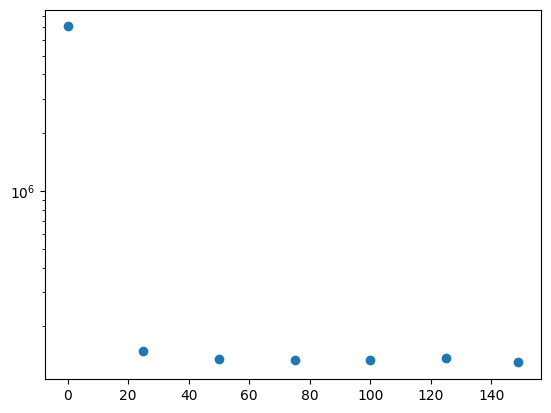

In [343]:
plt.scatter(batchi_test, loss_test)
plt.semilogy()

Text(0, 0.5, 'y pixel')

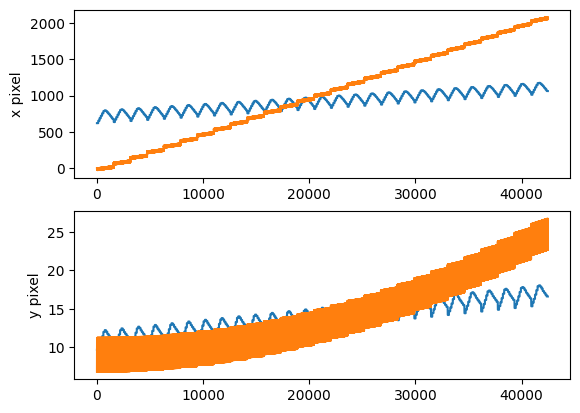

In [344]:
pred = nnmodel(X_test).cpu().detach().numpy()

gif, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(pred[:, 0])
ax1.plot(xm0.ravel())
ax1.set_ylabel('x pixel')

ax2.plot(pred[:, 1])
ax2.plot(ym0.ravel())
ax2.set_ylabel('y pixel')

No redshift model - this is 3 features so we have a chance to visualize it...

Text(0, 0.5, 'dec offset')

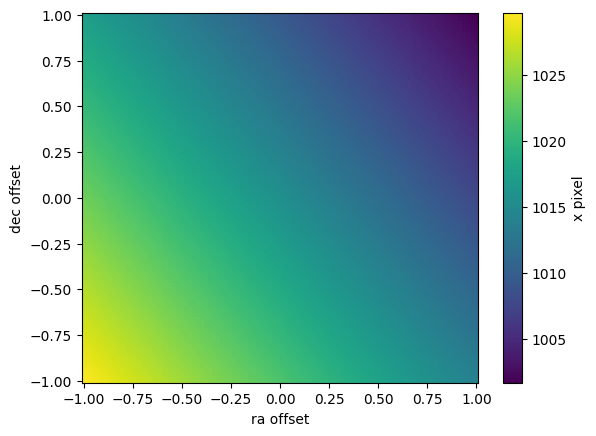

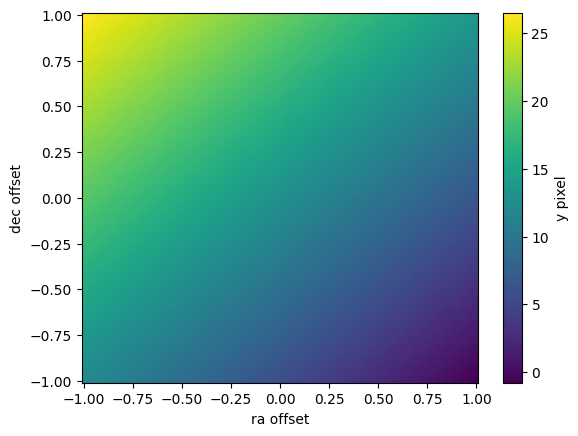

In [391]:
ro, do = np.mgrid[-1:1:100j, -1:1:100j]
sc = base_sc.spherical_offsets_by(ro<< u.arcsec, do<< u.arcsec)
xs, ys = slit.meta.wcs.world_to_pixel(sc, phoenix_lowres.spectral_axis[12060])

plt.figure()
plt.pcolor(ro, do, xs)
plt.colorbar().set_label('x pixel')
plt.xlabel('ra offset')
plt.ylabel('dec offset')

plt.figure()
plt.pcolor(ro, do, ys)
plt.colorbar().set_label('y pixel')
plt.xlabel('ra offset')
plt.ylabel('dec offset')

Text(0, 0.5, 'dec offset')

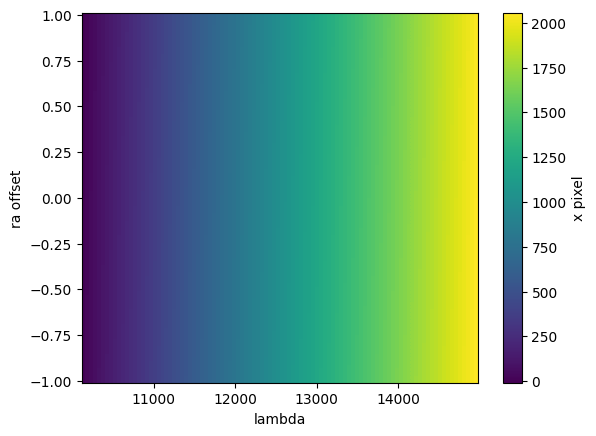

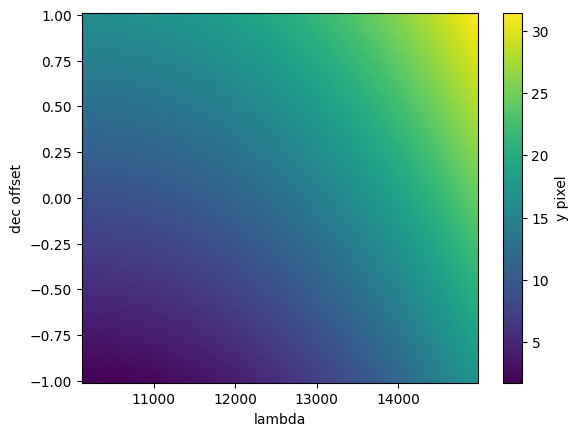

In [392]:
l, ro, do = np.mgrid[phoenix_lowres.spectral_axis[0]:phoenix_lowres.spectral_axis[-1]:100j, -1:1:100j, -1:1:100j]
sc = base_sc.spherical_offsets_by(ro<< u.arcsec, do<< u.arcsec)
xs, ys = slit.meta.wcs.world_to_pixel(sc, phoenix_lowres.spectral_axis.unit*l)



plt.figure()
sl = (slice(None), slice(None), 50)
plt.pcolor(l[sl], ro[sl], xs[sl])
plt.colorbar().set_label('x pixel')
plt.xlabel('lambda')
plt.ylabel('ra offset')

plt.figure()
sl = (slice(None), 50, slice(None))
plt.pcolor(l[sl], do[sl], ys[sl])
plt.colorbar().set_label('y pixel')
plt.xlabel('lambda')
plt.ylabel('dec offset')

Now try the model

In [393]:
param_simplers = 'lambda,raoff,decoff'.split(',')
lptp = np.ptp(phoenix_lowres.spectral_axis)
lmin = np.min(phoenix_lowres.spectral_axis)
def ptrans_simpler(urand): # 3 x batch size
    l = lptp*urand[0] + lmin
    ro = (urand[1]*2 - 1) << u.arcsec
    do = (urand[2]*2 - 1) << u.arcsec
    return l,ro,do

base_sc = SkyCoord(slit.source_ra<<u.deg, slit.source_dec<<u.deg)
def make_batch_simpler(rng, batch_size):
    l, ro, do = ptrans_simpler(rng.random(size=(len(param_simplers), batch_size)))
    l0 = l

    sc = base_sc.spherical_offsets_by(ro, do)
    
    outs = slit.meta.wcs.world_to_pixel(sc, l0)
    ins = np.array([l.value, ro.value, do.value])

    return ins, outs

In [394]:
def train_network_simpler(batch_size, n_batches, seed=42):
    nnmodel = NeuralNetwork(3, 2).to(torch_device)
    
    msk0 = gridallflat[1]==0
    X_test = torch.from_numpy(gridallflat.T[msk0][:, [0, 2, 3]].astype('float32')).to(torch_device)
    y_test = torch.from_numpy(np.array([xm0.ravel(), ym0.ravel()], dtype=np.float32).T[msk0]).to(torch_device)
    
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(nnmodel.parameters())
    
    rng = np.random.default_rng(seed)
    
    batchi_test = []
    loss_test = []
    
    nnmodel.train()
    for batchi in tqdm(list(range(n_batches))):
        ins, (xo, yo) = make_batch_simpler(rng, batch_size)
        X = torch.from_numpy(ins.T).to(torch_device, dtype=torch.float32)
        y = torch.from_numpy(np.array([xo, yo], dtype=np.float32).T).to(torch_device)
        
        # Compute prediction error
        pred = nnmodel(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        if batchi % 25 == 0 or batchi == (n_batches-1):
            with torch.no_grad():
                nnmodel.eval()
                batchi_test.append(batchi)
                loss_test.append(loss_fn(nnmodel(X_test), y_test).item())
                print('test loss at batch', batchi, 'is', loss_test[-1])
            nnmodel.train()
    
    nnmodel.eval()
    return nnmodel, X_test, y_test
    
nnmodel, X_test, y_test = train_network_simpler(1024, 1500, 42)

  0%|          | 0/1500 [00:00<?, ?it/s]

test loss at batch 0 is 7576755.0
test loss at batch 25 is 129873.234375
test loss at batch 50 is 127742.4140625
test loss at batch 75 is 128779.359375
test loss at batch 100 is 125057.7734375
test loss at batch 125 is 131583.234375
test loss at batch 150 is 134396.359375
test loss at batch 175 is 134017.765625
test loss at batch 200 is 130996.8828125
test loss at batch 225 is 132292.734375
test loss at batch 250 is 131536.265625
test loss at batch 275 is 127696.5703125
test loss at batch 300 is 133147.234375
test loss at batch 325 is 129838.703125
test loss at batch 350 is 131658.515625
test loss at batch 375 is 127092.71875
test loss at batch 400 is 129395.328125
test loss at batch 425 is 132785.71875
test loss at batch 450 is 128825.21875
test loss at batch 475 is 134923.765625
test loss at batch 500 is 125851.4921875
test loss at batch 525 is 126324.5703125
test loss at batch 550 is 128726.234375
test loss at batch 575 is 135954.40625
test loss at batch 600 is 121911.28125
test los

[]

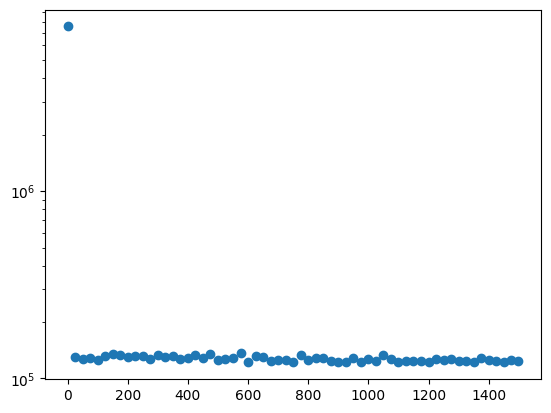

In [395]:
plt.scatter(batchi_test, loss_test)
plt.semilogy()

Text(0, 0.5, 'y pixel')

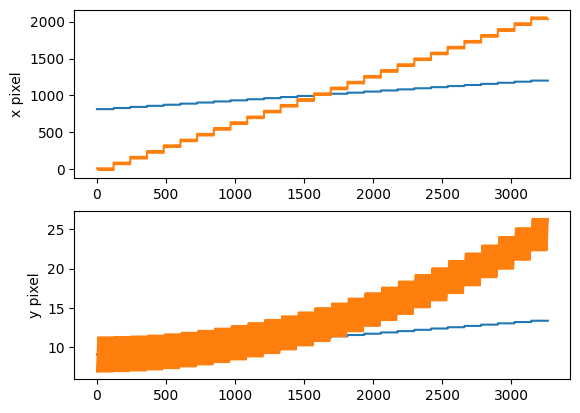

In [396]:
pred = nnmodel(X_test).cpu().detach().numpy()

gif, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(pred[:, 0])
ax1.plot(y_test.cpu().detach().numpy()[:, 0])
ax1.set_ylabel('x pixel')

ax2.plot(pred[:, 1])
ax2.plot(y_test.cpu().detach().numpy()[:, 1])

ax2.set_ylabel('y pixel')

  0%|          | 0/150 [00:00<?, ?it/s]

test loss at batch 0 is 10281056.0
test loss at batch 25 is 145099.578125
test loss at batch 50 is 135744.0625
test loss at batch 75 is 132974.703125
test loss at batch 100 is 132771.0
test loss at batch 125 is 135230.203125
test loss at batch 149 is 133518.265625


Text(0, 0.5, 'y pixel')

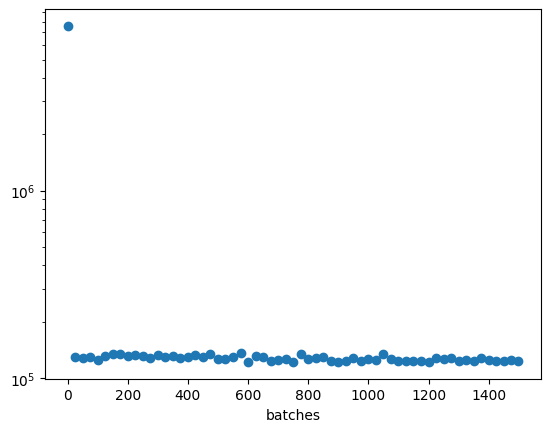

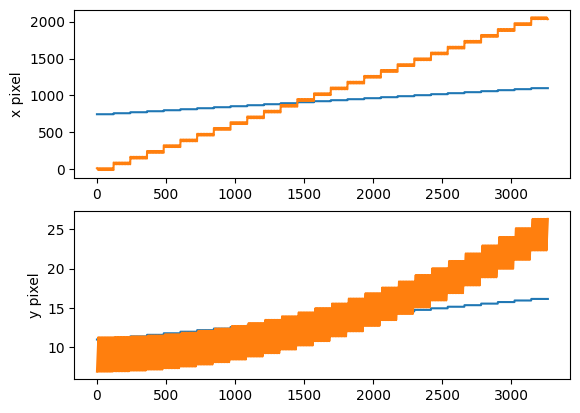

In [403]:
nnmodel, X_test, y_test = train_network_simpler(32768, 150, 43)

plt.scatter(batchi_test, loss_test)
plt.semilogy()

pred = nnmodel(X_test).cpu().detach().numpy()
plt.xlabel('batches')

gif, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(pred[:, 0])
ax1.plot(y_test.cpu().detach().numpy()[:, 0])
ax1.set_ylabel('x pixel')

ax2.plot(pred[:, 1])
ax2.plot(y_test.cpu().detach().numpy()[:, 1])

ax2.set_ylabel('y pixel')

Well lets at least see how fast it is

In [422]:
x_speed_test = torch.from_numpy(np.repeat(gridallflat.T[msk0][:, [0, 2, 3]],(30*2000)//np.sum(msk0), axis=0).astype('float32')).to(torch_device)

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
nnmodel(X_test)
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print(start.elapsed_time(end), 'ms')

0.6683200001716614 ms


Whoa ok that'll do it...

Below may be nonsense

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, outN):
        super().__init__()
        self.outN = outN
        self.primary_stack = nn.Sequential(
            nn.Linear(4, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, outN),
        )

    def forward(self, x):
        return self.primary_stack(x)

nnmodel = NeuralNetwork(1).to(torch_device)
print(nnmodel)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(nnmodel.parameters())

### NO batching

In [ ]:
nnmodel.train()

X = torch.from_numpy(xfit[::10]).to(torch_device, dtype=torch.float32)
y = torch.from_numpy(yfit).to(torch_device, dtype=torch.float32)

# Compute prediction error
pred = nnmodel(X)
loss = loss_fn(pred, y)

# Backpropagation
loss.backward()
optimizer.step()
optimizer.zero_grad()

loss.item()

In [ ]:
pred.shape, loss.shape, y.shape

In [ ]:
nnmodel.eval()

Xall = torch.from_numpy(xfit.astype('float32')).to(torch_device)
diff = (nnmodel(Xall).ravel() - y).cpu().detach().numpy()
plt.plot(diff)
plt.plot(yfit)

In [ ]:
xtt = xtimetest.astype('float32')

%timeit nnmodel(torch.from_numpy(xtt).to(torch_device)).cpu().detach().numpy()

In [ ]:
nnc = nnmodel.to('cpu')
%timeit nnc(torch.from_numpy(xtt)).detach().numpy()

Well the GPU is faster than most alternatives at least...

### Batching

In [ ]:
nnmodel = NeuralNetwork(1).to(torch_device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(nnmodel.parameters())

epochs = 5 

dssize = len(dl.dataset)
for ei in range(epochs):
    print('starting epoch', ei)
    
    scatteridx = np.random.permutation(xfit.shape[0])
    
    ds = TensorDataset(torch.from_numpy(xfit[scatteridx].astype('float32')), 
                       torch.from_numpy(yfit[scatteridx].astype('float32')))

    dl = DataLoader(ds, batch_size=2048)

    nnmodel.train()

    for batch, (X, y) in enumerate(dl):
        X = X.to(torch_device)
        y = y.to(torch_device)
        
        # Compute prediction error
        pred = nnmodel(X).ravel()  # not sure why/if this ravel is needed?
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{dssize:>5d}]")
    print('last batch num', batch)
    
    nnmodel.eval()
    
    Xall = torch.from_numpy(xfit.astype('float32')).to(torch_device)
    pred = nnmodel(Xall).ravel().cpu().detach().numpy()
    diff = (nnmodel(Xall).ravel() - ds.tensors[1].to(torch_device)).cpu().detach().numpy()
    
    plt.figure()
    #plt.plot(diff)
    plt.plot(pred)
    plt.plot(yfit)
    plt.title(str(ei))